In [20]:
### EDA　###

import pandas as pd
import numpy as np
from IPython.display import Image, display
import matplotlib.pyplot as plt
%matplotlib inline

# データの読み込み
train_df = pd.read_csv('../data/raw/train.csv')
test_df = pd.read_csv('../data/raw/test.csv')

In [21]:
# 欠損値 -1 を　 NaNに置き換える
train_df[['price_am', 'price_pm']] = train_df[['price_am', 'price_pm']].replace(-1, np.nan)
test_df[['price_am', 'price_pm']] = test_df[['price_am', 'price_pm']].replace(-1, np.nan)

display(train_df.shape, test_df.shape)
display(train_df.info(), test_df.info())
display(train_df.isnull().sum(), test_df.isnull().sum())
display(train_df.describe(), test_df.describe())

(2101, 6)

(365, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2101 entries, 0 to 2100
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  2101 non-null   object 
 1   y         2101 non-null   int64  
 2   client    2101 non-null   int64  
 3   close     2101 non-null   int64  
 4   price_am  1890 non-null   float64
 5   price_pm  1889 non-null   float64
dtypes: float64(2), int64(3), object(1)
memory usage: 98.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  365 non-null    object 
 1   client    365 non-null    int64  
 2   close     365 non-null    int64  
 3   price_am  360 non-null    float64
 4   price_pm  360 non-null    float64
dtypes: float64(2), int64(2), object(1)
memory usage: 14.4+ KB


None

None

datetime      0
y             0
client        0
close         0
price_am    211
price_pm    212
dtype: int64

datetime    0
client      0
close       0
price_am    5
price_pm    5
dtype: int64

,y,client,close,price_am,price_pm
count,2101.000000,2101.000000,2101.000000,1890.000000,1889.000000
mean,34.096621,0.098049,0.012851,0.794709,0.546850
std,17.476234,0.297451,0.112658,1.044370,0.903766
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,0.000000,0.000000,0.000000,0.000000
50%,32.000000,0.000000,0.000000,0.500000,0.000000
75%,45.000000,0.000000,0.000000,1.000000,1.000000
max,109.000000,1.000000,1.000000,5.000000,5.000000


,client,close,price_am,price_pm
count,365.000000,365.000000,360.000000,360.000000
mean,0.452055,0.013699,0.819444,0.608333
std,0.498379,0.116396,0.986347,0.946736
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,5.000000,5.000000


In [22]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    # データフレーム作成
    adf_df = pd.DataFrame(
        [
            adfuller(series)[1]
        ],
        columns=['P値']
    )
    # 有効数字3桁にする
    adf_df['P値'] = adf_df['P値'].round(decimals=3).astype(str)
    print(adf_df)

adf_test(series=train_df['y'])

      P値
0  0.575


In [23]:
# 訓練データとテストデータをマージ

train_df['is_train'] = 1
test_df['is_train'] = 0

train_cols = train_df.columns.tolist()
test_cols = test_df.columns.tolist()
common_cols = list(set(train_cols) & set(test_cols))
train_only = list(set(train_cols) - set(common_cols))
test_only = list(set(test_cols) - set(common_cols))

for col in train_only:
    test_df[col] = None

for col in test_only:
    train_df[col] = None

merged_df = pd.concat([train_df, test_df], ignore_index=True, sort=False)

merged_df['price'] = (merged_df['price_am'] + merged_df['price_pm']) / 2

pd.set_option('future.no_silent_downcasting', True)
merged_df['y'] = merged_df['y'].fillna(0).astype(int)

merged_df.head(190)

,datetime,y,client,close,price_am,price_pm,is_train,price
0,2010-07-01,17,0,0,NaN,NaN,1,NaN
1,2010-07-02,18,0,0,NaN,NaN,1,NaN
2,2010-07-03,20,0,0,NaN,NaN,1,NaN
3,2010-07-04,20,0,0,NaN,NaN,1,NaN
4,2010-07-05,14,0,0,NaN,NaN,1,NaN
...,...,...,...,...,...,...,...,...
185,2011-01-02,0,0,1,NaN,NaN,1,NaN
186,2011-01-03,0,0,1,NaN,NaN,1,NaN
187,2011-01-04,16,0,0,0.0,0.0,1,0.0
188,2011-01-05,16,0,0,0.0,0.0,1,0.0


In [24]:
merged_df['datetime'] = pd.to_datetime(merged_df['datetime'])
merged_df['year'] = merged_df['datetime'].apply(lambda x: x.year)
merged_df['month'] = merged_df['datetime'].apply(lambda x: x.month)
merged_df['weekday'] = merged_df['datetime'].apply(lambda x: x.weekday())
merged_df
#merged_df[['price_am', 'price_pm']].groupby('month').mean()

,datetime,y,client,close,price_am,price_pm,is_train,price,year,month,weekday
0,2010-07-01,17,0,0,NaN,NaN,1,NaN,2010,7,3
1,2010-07-02,18,0,0,NaN,NaN,1,NaN,2010,7,4
2,2010-07-03,20,0,0,NaN,NaN,1,NaN,2010,7,5
3,2010-07-04,20,0,0,NaN,NaN,1,NaN,2010,7,6
4,2010-07-05,14,0,0,NaN,NaN,1,NaN,2010,7,0
...,...,...,...,...,...,...,...,...,...,...,...
2461,2017-03-27,0,0,0,5.0,4.0,0,4.5,2017,3,0
2462,2017-03-28,0,0,0,4.0,4.0,0,4.0,2017,3,1
2463,2017-03-29,0,0,0,3.0,3.0,0,3.0,2017,3,2
2464,2017-03-30,0,0,0,4.0,3.0,0,3.5,2017,3,3


In [25]:
merged_df.set_index('datetime', inplace=True)
merged_df.index = pd.to_datetime(merged_df.index)
merged_df

,y,client,close,price_am,price_pm,is_train,price,year,month,weekday
datetime,,,,,,,,,,
2010-07-01,17,0,0,NaN,NaN,1,NaN,2010,7,3
2010-07-02,18,0,0,NaN,NaN,1,NaN,2010,7,4
2010-07-03,20,0,0,NaN,NaN,1,NaN,2010,7,5
2010-07-04,20,0,0,NaN,NaN,1,NaN,2010,7,6
2010-07-05,14,0,0,NaN,NaN,1,NaN,2010,7,0
...,...,...,...,...,...,...,...,...,...,...
2017-03-27,0,0,0,5.0,4.0,0,4.5,2017,3,0
2017-03-28,0,0,0,4.0,4.0,0,4.0,2017,3,1
2017-03-29,0,0,0,3.0,3.0,0,3.0,2017,3,2


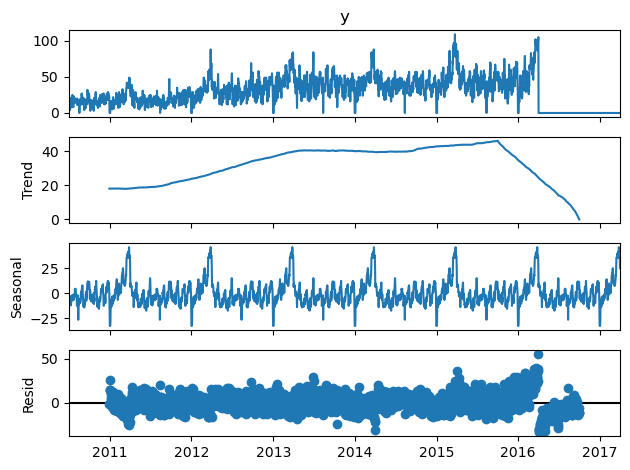

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose

# 季節性、トレンドの確認
price_am_seasonal = seasonal_decompose(merged_df['y'], model='additive', period=365)

# 分解結果のプロット
fig = price_am_seasonal.plot()
plt.show()

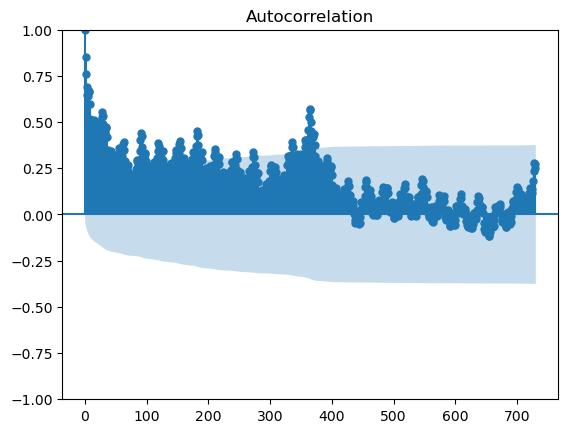

In [27]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(train_df['y'], lags=730)
plt.show()

In [30]:
# 日付（datetime）　を index　にする
merged_df_copy = merged_df.copy()

# 月と曜日ごとの平均価格を計算
merged_df_m_w = merged_df_copy.groupby(['month', 'weekday'])[['price_am', 'price_pm']].mean().reset_index()

print('月と曜日毎の平均：')
print(merged_df_m_w.head(20))

# 欠損値を月と曜日ごとの平均価格で埋める関数
def fill_missing_price_am(row):
    if pd.isna(row['price_am']):
        # 条件に一致する行を取得
        return merged_df_m_w[
            (merged_df_m_w['month'] == row['month']) &
            (merged_df_m_w['weekday'] == row['weekday'])
        ]['price_am'].values[0]
    return row['price_am']

def fill_missing_price_pm(row):
    if pd.isna(row['price_pm']):
        # 条件に一致する行を取得
        return train_m_w[
            (merged_df_m_w['month'] == row['month']) &
            (merged_df_m_w['weekday'] == row['weekday'])
        ]['price_pm'].values[0]
    return row['price_pm']

# 欠損値を埋める
merged_df['price_am'] = merged_df.apply(fill_missing_price_am, axis=1)
merged_df['price_pm'] = merged_df.apply(fill_missing_price_pm, axis=1)
merged_df['price'] = (merged_df['price_am'] + merged_df['price_pm']) / 2

merged_df.head(50)

月と曜日毎の平均：
    month  weekday  price_am  price_pm
0       1        0  0.142857  0.000000
1       1        1  0.107143  0.071429
2       1        2  0.035714  0.000000
3       1        3  0.178571  0.107143
4       1        4  0.285714  0.178571
5       1        5  0.892857  0.464286
6       1        6  0.428571  0.250000
7       2        0  0.586207  0.344828
8       2        1  0.357143  0.178571
9       2        2  0.379310  0.206897
10      2        3  0.357143  0.142857
11      2        4  0.821429  0.500000
12      2        5  2.071429  1.535714
13      2        6  1.392857  0.892857
14      3        0  1.933333  1.666667
15      3        1  2.000000  1.580645
16      3        2  1.838710  1.709677
17      3        3  2.031250  1.656250
18      3        4  2.096774  2.032258
19      3        5  3.096774  2.741935


,y,client,close,price_am,price_pm,is_train,price,year,month,weekday
datetime,,,,,,,,,,
2010-07-01,17,0,0,0.192308,0.076923,1,0.134615,2010,7,3
2010-07-02,18,0,0,0.692308,0.423077,1,0.557692,2010,7,4
2010-07-03,20,0,0,1.807692,1.192308,1,1.500000,2010,7,5
2010-07-04,20,0,0,1.407407,0.925926,1,1.166667,2010,7,6
2010-07-05,14,0,0,0.346154,0.192308,1,0.269231,2010,7,0
2010-07-06,14,0,0,0.333333,0.148148,1,0.240741,2010,7,1
2010-07-07,4,0,0,0.259259,0.111111,1,0.185185,2010,7,2
2010-07-08,10,0,0,0.192308,0.076923,1,0.134615,2010,7,3
2010-07-09,12,0,0,0.692308,0.423077,1,0.557692,2010,7,4


In [31]:
# ラグ特徴量の追加
merged_df['y_lag_365'] = merged_df['y'].shift(365)

for lag in [1, 7, 365]:
    merged_df[f'price_am_lag_{lag}'] = merged_df['price_am'].shift(lag)

for lag in [1, 7, 365]:
    merged_df[f'price_pm_lag_{lag}'] = merged_df['price_pm'].shift(lag)


# 移動平均の追加
windows = [7, 30]
for window in windows:
    merged_df[f'price_am_moving_avg_{window}'] = merged_df['price_am'].rolling(window=window).mean()

for window in windows:
    merged_df[f'price_pm_moving_avg_{window}'] = merged_df['price_pm'].rolling(window=window).mean()

In [32]:
merged_df['year'] = list(pd.Series(merged_df.index).apply(lambda x: x.year))
merged_df['month'] = list(pd.Series(merged_df.index).apply(lambda x: x.month))
merged_df['day'] = list(pd.Series(merged_df.index).apply(lambda x: x.day))

In [33]:
display(merged_df)

,y,client,close,price_am,price_pm,is_train,price,year,month,weekday,...,price_am_lag_7,price_am_lag_365,price_pm_lag_1,price_pm_lag_7,price_pm_lag_365,price_am_moving_avg_7,price_am_moving_avg_30,price_pm_moving_avg_7,price_pm_moving_avg_30,day
datetime,,,,,,,,,,,,,,,,,,,,,
2010-07-01,17,0,0,0.192308,0.076923,1,0.134615,2010,7,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2010-07-02,18,0,0,0.692308,0.423077,1,0.557692,2010,7,4,...,NaN,NaN,0.076923,NaN,NaN,NaN,NaN,NaN,NaN,2
2010-07-03,20,0,0,1.807692,1.192308,1,1.500000,2010,7,5,...,NaN,NaN,0.423077,NaN,NaN,NaN,NaN,NaN,NaN,3
2010-07-04,20,0,0,1.407407,0.925926,1,1.166667,2010,7,6,...,NaN,NaN,1.192308,NaN,NaN,NaN,NaN,NaN,NaN,4
2010-07-05,14,0,0,0.346154,0.192308,1,0.269231,2010,7,0,...,NaN,NaN,0.925926,NaN,NaN,NaN,NaN,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-03-27,0,0,0,5.000000,4.000000,0,4.500000,2017,3,0,...,3.0,5.0,4.000000,4.0,4.0,3.857143,2.166667,4.000000,2.166667,27
2017-03-28,0,0,0,4.000000,4.000000,0,4.000000,2017,3,1,...,4.0,4.0,4.000000,4.0,4.0,3.857143,2.233333,4.000000,2.233333,28
2017-03-29,0,0,0,3.000000,3.000000,0,3.000000,2017,3,2,...,2.0,4.0,4.000000,4.0,4.0,4.000000,2.266667,3.857143,2.266667,29


In [34]:
merged_df.to_csv('processed20240826')